In [5]:
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
custom_colors = ['#c47a74', '#93c47d', '#b4a7d6', '#f9cb9c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
complementary_colors = ['#a9d0f5', '#f3ba8c', '#98e698', '#f5a9a9', '#d8b5d8', '#d2a6a6', '#f5a9f2', '#d8d8d8']

full_palette = custom_colors + complementary_colors
sns.set_palette(full_palette)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [7]:
df = pd.read_pickle('../data/depresjon/depresjon_preprocessed.pkl')
df = df[df['category_madrs'].notna()]
df

,user_id,activity,days,gender,age,afftype,melanch,inpatient,edu,marriage,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1,174.144444,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,1,156.247222,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,1,124.135417,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,1,134.961806,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,1,99.439583,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,9,162.295833,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,-0.781831,-0.481754,0.937752,0.623490,0.623490,0.876307,0.347305,1,0
401,9,224.508333,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,0.000000,-0.24869,0.988468,0.623490,1.000000,0.968583,0.151428,1,2
402,9,202.056250,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,0.781831,-0.24869,0.998717,0.623490,0.623490,0.968583,-0.050649,1,2
403,9,168.656250,13,2,2,1.0,2.0,2.0,1,1.0,...,-0.781831,0.974928,-0.24869,0.968077,0.623490,-0.222521,0.968583,-0.250653,1,1


In [8]:
df.columns

Index(['user_id', 'activity', 'days', 'gender', 'age', 'afftype', 'melanch',
       'inpatient', 'edu', 'marriage', 'work', 'is_weekend', 'category_madrs',
       'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos',
       'weekday_cos', 'week_cos', 'day_cos', 'activity_quantile',
       'user_activity_quantile'],
      dtype='object')

In [9]:
df['age'].value_counts()

2    154
1    109
3     64
0     46
4     16
Name: age, dtype: int64

In [10]:
df['age'].replace(to_replace=[0,1,2,3,4],
                      value=[0, 1,1,1,1], inplace=True)

In [11]:
df['age'].value_counts()

1    343
0     46
Name: age, dtype: int64

In [12]:
df['gender'].value_counts()

2    220
1    169
Name: gender, dtype: int64

In [13]:
df['category_madrs'].value_counts()

0    201
1    188
Name: category_madrs, dtype: int64

# Significant relations between labels and protected attributes

In [14]:
demographic_variables = ['age', 'gender']
target_variables = ['category_madrs']

def perform_chi2_test(df, demographic_variable, target_variable):
    contingency_table = pd.crosstab(df[demographic_variable], df[target_variable])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

results_df = pd.DataFrame(columns=['Demographic Variable', 'Target Variable', 'Chi-square Statistic', 'p-value'])

for demographic_variable in demographic_variables:
    for target_variable in target_variables:
        chi2, p = perform_chi2_test(df, demographic_variable, target_variable)
        temp_df = pd.DataFrame({
            'Demographic Variable': [demographic_variable],
            'Target Variable': [target_variable],
            'Chi-square Statistic': [chi2],
            'p-value': [p]
        })
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df

,Demographic Variable,Target Variable,Chi-square Statistic,p-value
0,age,category_madrs,5.216137,0.022378
1,gender,category_madrs,15.406562,0.000087


if p<0.05 there is a significant relation

# Representation bias

In [15]:
ratios = {
    'Category': ['gender', 'age'],
    'Dataset Ratios': [0.57, 0.12], # male, below 30
    'Real Ratios': [0.48, 0.32] # male, below 30
}

ratios_df = pd.DataFrame(ratios)
ratios_df

,Category,Dataset Ratios,Real Ratios
0,gender,0.57,0.48
1,age,0.12,0.32


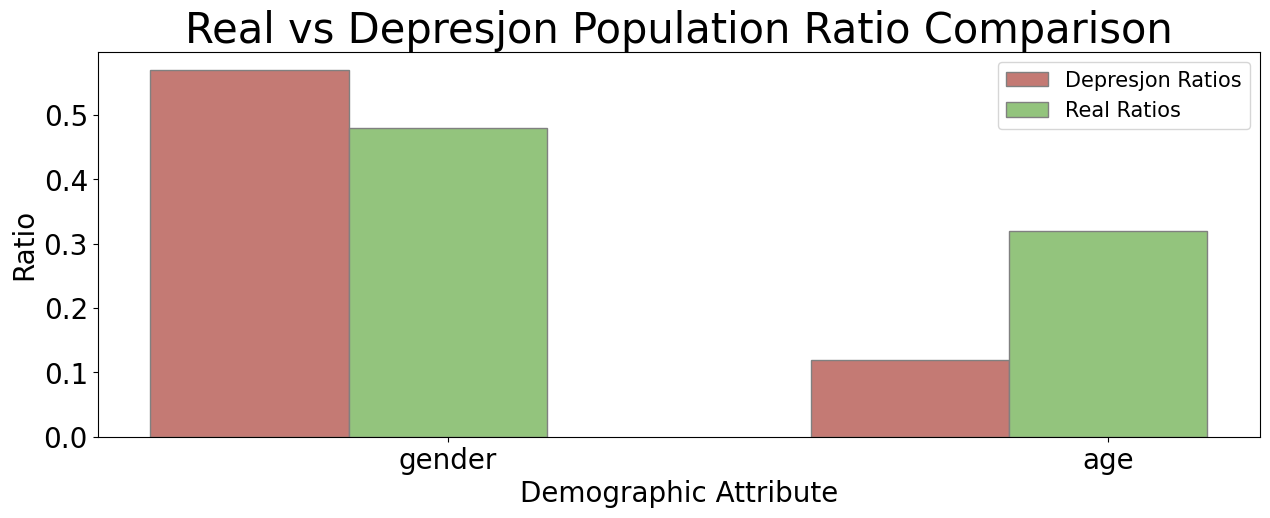

In [16]:
plt.figure(figsize=(15, 5))

barWidth = 0.3

r1 = range(len(ratios_df))
r2 = [x + barWidth for x in r1]

plt.bar(r1, ratios_df['Dataset Ratios'], color='#c47a74', width=barWidth, edgecolor='grey', label='Depresjon Ratios')
plt.bar(r2, ratios_df['Real Ratios'], color='#93c47d', width=barWidth, edgecolor='grey', label='Real Ratios')

plt.xlabel('Demographic Attribute')
plt.xticks([r + barWidth for r in range(len(ratios_df))], ratios_df['Category'])
plt.ylabel('Ratio')
plt.title('Real vs Depresjon Population Ratio Comparison')
plt.legend()
plt.savefig("../visualizations/depresjon/representation-biasDepresjon.png",bbox_inches='tight')
plt.savefig("../visualizations/depresjon/representation-biasDepresjon.eps",bbox_inches='tight')
plt.show()

# Data biases

In [17]:
df = df.drop(columns=['user_id'])
df

,activity,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,174.144444,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,156.247222,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,124.135417,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,134.961806,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,99.439583,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,162.295833,13,2,1,1.0,2.0,2.0,1,1.0,2.0,...,-0.781831,-0.781831,-0.481754,0.937752,0.623490,0.623490,0.876307,0.347305,1,0
401,224.508333,13,2,1,1.0,2.0,2.0,1,1.0,2.0,...,-0.781831,0.000000,-0.24869,0.988468,0.623490,1.000000,0.968583,0.151428,1,2
402,202.056250,13,2,1,1.0,2.0,2.0,1,1.0,2.0,...,-0.781831,0.781831,-0.24869,0.998717,0.623490,0.623490,0.968583,-0.050649,1,2
403,168.656250,13,2,1,1.0,2.0,2.0,1,1.0,2.0,...,-0.781831,0.974928,-0.24869,0.968077,0.623490,-0.222521,0.968583,-0.250653,1,1


In [18]:
protected_attributes = ['gender', 'age']
privileged_classes = [[2], [0]] # male, below 30 years old

dataset = StandardDataset(df,
                          label_name='category_madrs',
                          favorable_classes=[1],  # not a favorable outcome, but perhaps the most important
                          protected_attribute_names=protected_attributes,
                          privileged_classes=privileged_classes)

df_bias_columns_metric = pd.DataFrame(columns=['protected_attribute', 'statistical_parity_difference', 'disparate_impact_ratio'])

for attr in dataset.protected_attribute_names:
    print("\nEvaluating Outcome Bias for {}".format(attr))
    idx = dataset.protected_attribute_names.index(attr)
    privileged_groups = [{attr: dataset.privileged_protected_attributes[idx][0]}]
    unprivileged_groups = [{attr: dataset.unprivileged_protected_attributes[idx][0]}]

    metric_data = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)

    # Using mean_difference() value as Statistical Parity Difference for explicit naming
    spd = metric_data.mean_difference()

    df_bias_columns_metric.loc[len(df_bias_columns_metric.index)] = [attr, spd, metric_data.disparate_impact()]

    print("Group Fairness - Statistical Parity Difference: {}".format(spd))
    print("Group Fairness - Disparate Impact Ratio: {}".format(metric_data.disparate_impact()))

df_bias_columns_metric


Evaluating Outcome Bias for gender
Group Fairness - Statistical Parity Difference: -0.20586336740182898
Group Fairness - Disparate Impact Ratio: 0.6405560251714097

Evaluating Outcome Bias for age
Group Fairness - Statistical Parity Difference: -0.19153251362656865
Group Fairness - Disparate Impact Ratio: 0.7063168124392614


,protected_attribute,statistical_parity_difference,disparate_impact_ratio
0,gender,-0.205863,0.640556
1,age,-0.191533,0.706317


Statistical Parity Difference measures the difference in the rate of favorable outcomes received by the unprivileged group compared to the privileged group. A value of 0 indicates perfect fairness. Disparate Impact Ratio measures the ratio of probabilities of favorable outcomes for the unprivileged group to that of the privileged group. A value of 1 indicates perfect fairness, values less than 1 indicate less favorable outcomes for the unprivileged group, and values greater than 1 indicate more favorable outcomes for the unprivileged group.

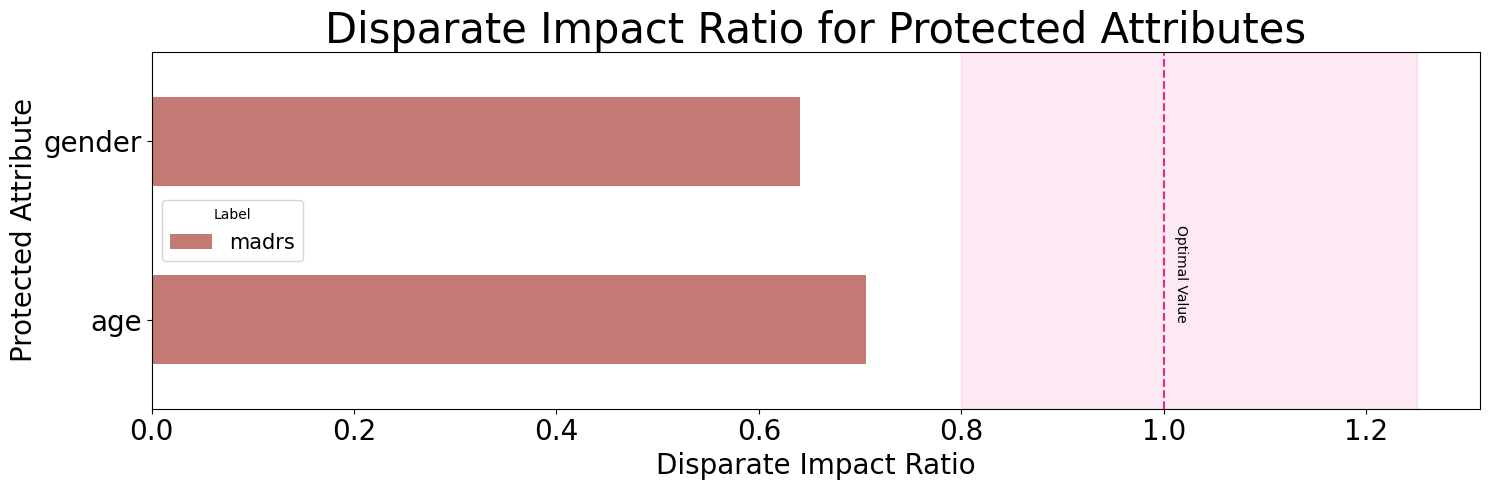

In [19]:
df_bias_columns_metric['Label'] = 'madrs'



pivot_df = df_bias_columns_metric.pivot(index='protected_attribute', columns='Label', values='disparate_impact_ratio')

pivot_df.plot(kind='barh', figsize=(15, 5))
plt.axvline(x=1.0, color='#e72a8a', linestyle='--')
plt.axvspan(0.8, 1.25, color='#e72a8a', alpha=0.1)
plt.text(1.01, 0, 'Optimal Value', rotation=270)
plt.ylabel('Protected Attribute')
plt.xlabel('Disparate Impact Ratio')
plt.title('Disparate Impact Ratio for Protected Attributes')
plt.legend(title='Label')
plt.tight_layout()
plt.savefig("../visualizations/depresjon/dir-data-biasdepresjon.png",bbox_inches='tight')
plt.savefig("../visualizations/depresjon/dir-data-biasdepresjon.eps",bbox_inches='tight')
plt.show()

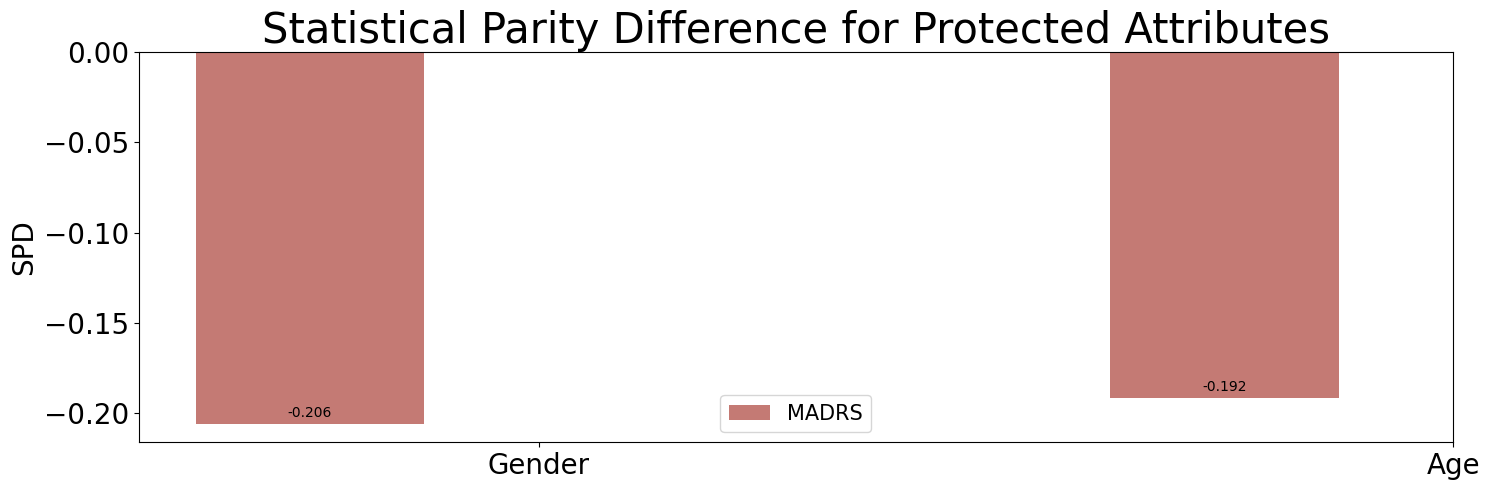

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Corrected assignments for each measure
spd_madrs = np.array([-0.205863, -0.191533])  

attributes = ['Gender', 'Age']
x = np.arange(len(attributes))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width, spd_madrs, width, label='MADRS')
#rects2 = ax.bar(x, spd_panas, width, label='PANAS')
#rects3 = ax.bar(x + width, spd_stai, width, label='STAI')

ax.set_ylabel('SPD')
ax.set_title('Statistical Parity Difference for Protected Attributes')
ax.set_xticks(x)
ax.set_xticklabels(attributes)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
plt.savefig("../visualizations/depresjon/spd-data-biasdepresjon.png",bbox_inches='tight')
plt.savefig("../visualizations/depresjon/spd-data-biasdepresjon.eps",bbox_inches='tight')
fig.tight_layout()
plt.show()


# Model bias

In [21]:
X_test = pd.read_csv('../data/depresjon/predictions/depresjon_X_test_generic.csv')
X_test

,activity,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,0.119220,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-1.017878,1.324710,-1.212424,1.330479,-0.307385,-0.286323,0.002097,0.380412,1,1
1,-0.039811,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-1.017878,0.557796,-1.212424,1.344905,-0.307385,-1.245538,0.002097,0.088993,1,1
2,-0.325151,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-1.017878,-0.672240,-1.212424,1.301775,-0.307385,-1.245538,0.002097,-0.199435,1,1
3,-0.228950,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-1.017878,-1.439155,-1.212424,1.202855,-0.307385,-0.286323,0.002097,-0.473064,1,1
4,-0.544594,11,2,1,2.0,2.0,2.0,1,1.0,2.0,...,-1.017878,-1.165447,-1.212424,1.052194,-0.307385,0.909798,0.002097,-0.720693,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.800843,13,2,3,2.0,2.0,2.0,2,2.0,2.0,...,-0.774605,-0.057222,0.842143,-1.466815,1.143051,1.442123,1.213349,0.088993,2,2
89,0.366036,13,2,3,2.0,2.0,2.0,2,2.0,2.0,...,-0.774605,1.051002,0.842143,-1.452389,1.143051,0.909798,1.213349,0.380412,1,2
90,0.377539,13,2,3,2.0,2.0,2.0,2,2.0,2.0,...,-0.774605,1.324710,0.842143,-1.380998,1.143051,-0.286323,1.213349,0.662890,1,2
91,-0.628201,13,2,3,2.0,2.0,2.0,2,2.0,2.0,...,-0.774605,0.557796,0.842143,-1.255563,1.143051,-1.245538,1.213349,0.924863,1,0


In [22]:
y_test = pd.read_csv('../data/depresjon/predictions/depresjon_y_test_generic.csv')
y_test

,category_madrs
0,1
1,1
2,1
3,1
4,1
...,...
88,0
89,0
90,0
91,0


In [23]:
y_pred = pd.read_csv('../data/depresjon/predictions/depresjon_pred_generic.csv')
y_pred

,category_madrs
0,0
1,0
2,0
3,0
4,0
...,...
88,0
89,0
90,0
91,0


In [24]:
print("Missing values in X_test:", X_test.isna().any().any())
print("Missing values in y_test:", y_test.isna().any())
print("Missing values in y_pred:", pd.DataFrame(y_pred).isna().any().any())

Missing values in X_test: False
Missing values in y_test: category_madrs    False
dtype: bool
Missing values in y_pred: False


In [25]:
print(X_test.index)
print(y_test.index)
print(y_pred.index)

RangeIndex(start=0, stop=93, step=1)
RangeIndex(start=0, stop=93, step=1)
RangeIndex(start=0, stop=93, step=1)


In [26]:
protected_attributes = ['gender', 'age']
privileged_classes = [[2], [0]] # male, below 30 years old

true_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([X_test, y_test], axis=1),
    label_names=['category_madrs'],
    protected_attribute_names=protected_attributes
)

pred_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([X_test, y_pred], axis=1),
    label_names=['category_madrs'],
    protected_attribute_names=protected_attributes
)

In [27]:
privileged_groups = [{'gender': 2, 'age': 0}]  # male, below 30 years old
unprivileged_groups = [{'gender': 1, 'age': 1}]

dataset_metric = BinaryLabelDatasetMetric(
    true_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

classification_metric = ClassificationMetric(
    true_dataset,
    pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
print("Generic model")
print("----------------")
print("Disparate Impact:", dataset_metric.disparate_impact())
print("Statistical Parity Difference:", dataset_metric.statistical_parity_difference())

Generic model
----------------
Disparate Impact: nan
Statistical Parity Difference: nan


C:\Users\ChristinaKaragianni\anaconda3\envs\py38\lib\site-packages\aif360\metrics\binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)
